In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pyod.models import knn
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import linear_model
import json
import joblib
# from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [4]:
data_dir = "./wtbdata_245days.csv"
train = pd.read_csv(data_dir)
train.head(-5)

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727510,134,245,22:20,6.60,2.87,-0.30,3.38,203.44,0.02,0.02,0.02,-10.09,593.52
4727511,134,245,22:30,6.82,-0.08,-0.26,3.46,207.97,0.02,0.02,0.02,33.11,644.20
4727512,134,245,22:40,6.52,3.81,-0.45,3.44,212.32,0.02,0.01,0.01,-14.46,596.79
4727513,134,245,22:50,6.81,5.51,-0.60,3.40,216.51,0.02,0.01,0.01,-62.62,664.56


In [5]:
print(len(train))
train.info()

4727520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [6]:
train.isnull().any()

TurbID     False
Day        False
Tmstamp    False
Wspd        True
Wdir        True
Etmp        True
Itmp        True
Ndir        True
Pab1        True
Pab2        True
Pab3        True
Prtv        True
Patv        True
dtype: bool

In [7]:
train.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       49518
Wdir       49518
Etmp       49518
Itmp       49518
Ndir       49518
Pab1       49518
Pab2       49518
Pab3       49518
Prtv       49518
Patv       49518
dtype: int64

In [8]:
print('NULL:', (49518 / 4727520) * 100)

NULL: 1.0474413646055436


### 数据分析：0值 缺失值 未知值 异常值 

In [9]:
train['Patv'][0] < 0
zero_data = train[(train['Patv'] < 0)]
print(len(zero_data))
print('Zero values:', (len(zero_data) / 4727520) * 100)

unknown_data_0 = train[(train['Patv'] <= 0) & (train['Wspd'] > 2.5)]
print(len(unknown_data_0))
print('Unknown values_0:', (len(unknown_data_0) / 4727520) * 100)

unknown_data_1 = train[(train['Pab1'] > 89) | (train['Pab2'] > 89) | (train['Pab3'] > 89) ]
print(len(unknown_data_1))
print('Unknown values_1:', (len(unknown_data_1) / 4727520) * 100)

unknown_data = train[(train['Patv'] <= 0) & (train['Wspd'] > 2.5) | (train['Pab1'] > 89) | (train['Pab2'] > 89) | (train['Pab3'] > 89) ]
print(len(unknown_data))
print('Unknown values:', (len(unknown_data) / 4727520) * 100)

abnormal_data = train[(train['Ndir'] < -720) | (train['Ndir'] > 720) | (train['Wdir'] < -180) | (train['Wdir'] > 180) ]
print(len(abnormal_data))
print('Abnormal values:', (len(abnormal_data) / 4727520) * 100)

1263062
Zero values: 26.717221714556473
299094
Unknown values_0: 6.326657528683115
984595
Unknown values_1: 20.826881747723966
1082113
Unknown values: 22.88965461806613
127
Abnormal values: 0.002686397942261482


In [10]:
total_data = train[(train['Patv'] <= 0) & (train['Wspd'] > 2.5) | (train['Pab1'] > 89) | (train['Pab2'] > 89) | (train['Pab3'] > 89) \
    | (train['Patv'] < 0) \
    | (train['Ndir'] < -720) | (train['Ndir'] > 720) | (train['Wdir'] < -180) | (train['Wdir'] > 180) ]
print(len(total_data))
print('Total values:', (len(total_data) / 4727520) * 100)

1354025
Total values: 28.64133837614648


In [11]:
mask_data = train[(train['Patv'] <= 0) & (train['Wspd'] > 2.5) | (train['Pab1'] > 89) | (train['Pab2'] > 89) | (train['Pab3'] > 89) \
    | (train['Ndir'] < -720) | (train['Ndir'] > 720) | (train['Wdir'] < -180) | (train['Wdir'] > 180) ]
print(len(mask_data))
print('mask values:', (len(mask_data) / 4727520) * 100)

1082143
mask values: 22.890289200257214


##### 问题数据占比是28.64%,相比nan的数据占比是1.05%。现在是nan直接填充0，这样子模型其实有可能会受到问题数据的影响，导致模型不同程度的出现偏差和波动。在线上评估中问题数据大部分不用预测，评估程序不会计入本部分的结果。因此，初步想法是，采用位置embedding，告诉模型的那些不重要；还有一个操作是可以问题数据的loss梯度取消；还是通过数据清洗和异常处理进行纠正。

In [12]:
data_dir = "./wtbdata_245days.csv"
data = pd.read_csv(data_dir, index_col=None, header=0)
print(len(data))

part_data_list = list(data.groupby("TurbID"))
time_set = np.unique(part_data_list[0][1]["Tmstamp"].values)
assert len(time_set) == 144
time_set = sorted(time_set.tolist())
time_dict = {}
for i in range(len(time_set)):
    time_dict[time_set[i]] = i
print(time_dict)

4727520
{'00:00': 0, '00:10': 1, '00:20': 2, '00:30': 3, '00:40': 4, '00:50': 5, '01:00': 6, '01:10': 7, '01:20': 8, '01:30': 9, '01:40': 10, '01:50': 11, '02:00': 12, '02:10': 13, '02:20': 14, '02:30': 15, '02:40': 16, '02:50': 17, '03:00': 18, '03:10': 19, '03:20': 20, '03:30': 21, '03:40': 22, '03:50': 23, '04:00': 24, '04:10': 25, '04:20': 26, '04:30': 27, '04:40': 28, '04:50': 29, '05:00': 30, '05:10': 31, '05:20': 32, '05:30': 33, '05:40': 34, '05:50': 35, '06:00': 36, '06:10': 37, '06:20': 38, '06:30': 39, '06:40': 40, '06:50': 41, '07:00': 42, '07:10': 43, '07:20': 44, '07:30': 45, '07:40': 46, '07:50': 47, '08:00': 48, '08:10': 49, '08:20': 50, '08:30': 51, '08:40': 52, '08:50': 53, '09:00': 54, '09:10': 55, '09:20': 56, '09:30': 57, '09:40': 58, '09:50': 59, '10:00': 60, '10:10': 61, '10:20': 62, '10:30': 63, '10:40': 64, '10:50': 65, '11:00': 66, '11:10': 67, '11:20': 68, '11:30': 69, '11:40': 70, '11:50': 71, '12:00': 72, '12:10': 73, '12:20': 74, '12:30': 75, '12:40': 76, 

In [13]:
num = 0
for i in range(len(part_data_list)):
    num += len(part_data_list[i][1])
print(num)

4727520


In [14]:
print("Wspd", np.min(data["Wspd"]), np.max(data["Wspd"]))
print("Wdir",np.min(data["Wdir"]),np.max(data["Wdir"]))
print("Etmp", np.min(data["Etmp"]), np.max(data["Etmp"]))
print("Itmp", np.min(data["Itmp"]), np.max(data["Itmp"]))
print("Ndir",np.min(data["Ndir"]),np.max(data["Ndir"]))
print("Pab1", np.min(data["Pab1"]), np.max(data["Pab1"]))
print("Pab2", np.min(data["Pab2"]), np.max(data["Pab2"]))
print("Pab3", np.min(data["Pab3"]), np.max(data["Pab3"]))
print("Prtv", np.min(data["Prtv"]), np.max(data["Prtv"]))

Wspd 0.0 26.29
Wdir -3030.46 2266.95
Etmp -273.03 394.33
Itmp -273.17 324.21
Ndir -884.86 700.62
Pab1 -10.0 99.98
Pab2 -10.0 99.98
Pab3 -10.0 99.98
Prtv -624.98 485.2


In [15]:
a_idx = data["Ndir"] < -720
# print(data.loc[a_idx,["Ndir"]])
print(len(data.loc[a_idx, ["Ndir"]]))
b_idx = data["Wdir"] < -180
# print(data.loc[b_idx,["Wdir"]])
print(len(data.loc[b_idx, ["Wdir"]]))
c_idx = data['Pab1'] < -1
# print(data.loc[c_idx,["Pab1"]])
print(len(data.loc[c_idx, ["Pab1"]]))


49
37
52679


In [35]:
def plot_abnormal(name, data, abnormal_idx):
    x1 = data.loc[abnormal_idx, ["Wspd"]]
    y1 = data.loc[abnormal_idx, ["Patv"]]
    x2 = data.loc[~abnormal_idx, ["Wspd"]]
    y2 = data.loc[~abnormal_idx, ["Patv"]]
    print("turbine", name, len(x1)/len(data))
    plt.figure(figsize=(10, 6))
    plt.scatter(x2, y2, s=5)
    plt.scatter(x1, y1, s=5)
    plt.xlabel("wind")
    plt.ylabel("power")
    plt.show()


def pyod_KNN(data, outliers_fraction=0.05, show=False, fig_name='abnormal'):
    WIND = "Wspd"
    norm_data = data[[WIND, "Patv"]].copy()
    norm_data[WIND] = norm_data[WIND]/max(norm_data[WIND])
    norm_data["Patv"] = norm_data["Patv"]/max(norm_data["Patv"])

    # fit the model
    # clf = LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)
    clf = IsolationForest(n_estimators=200, contamination=0.05, random_state=np.random.RandomState(42))
    y_pred = clf.fit_predict(norm_data)
    # scores_pred = clf.negative_outlier_factor_
    # threshold = clf.offset_
    # threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)  # 根据异常样本比例，得到阈值，用于绘图

    good_idx = y_pred == 1
    bad_idx = y_pred == -1

    # =============plot=================
    good_data = data.loc[good_idx, :]
    bad_data = data.loc[bad_idx, :]
    print("good_num:{} bad_num:{}".format(len(good_data), len(bad_data)))
    if show == True:
        plt.figure(figsize=(10, 6))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.tick_params(labelsize=20)

        plt.scatter(good_data[WIND], good_data["Patv"], s=5,)
        plt.scatter(bad_data[WIND], bad_data["Patv"], s=5,)
        plt.xlabel("wind", fontsize=20)
        plt.ylabel("power", fontsize=20)
        plt.savefig(f'{fig_name}.png', dpi=600)
        plt.show()
        
    return good_data, bad_data


# 修正异常值
# 目前只用风速进行了修复
def pair_data(train_val_data, test_data, p=5, show=False, fig_name='1'):
    print(train_val_data.columns)
    # ['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
    # x_col = list(train_val_data.columns)
    # x_col.remove(['TurbID', 'Day', 'Tmstamp', 'Patv'])
    x_col = ['Wspd']

    x_train, x_val, y_train, y_val = train_test_split(
        train_val_data[x_col], train_val_data["Patv"], test_size=0.2, shuffle=True)
    gbm = LGBMRegressor(objective='regression', num_leaves=31,
                        learning_rate=0.1, n_estimators=500, )
    gbm.fit(x_train, y_train, eval_set=[
            (x_val, y_val)], eval_metric='l2', early_stopping_rounds=5, verbose=0)
    pre_Y = gbm.predict(test_data[x_col])
    test_data["Patv"] = pre_Y

    # joblib.dump(gbm, f"lgb_model_p{p}.pkl")
    WIND = "Wspd"
    if show == True:
        plt.figure(figsize=(10, 6))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.tick_params(labelsize=20)

        plt.scatter(train_val_data[WIND], train_val_data["Patv"], s=5,)
        plt.scatter(test_data[WIND], test_data["Patv"], s=5,)
        plt.xlabel("wind", fontsize=20)
        plt.ylabel("power", fontsize=20)
        plt.savefig(f'{fig_name}.png', dpi=600)
        plt.show()
        
    return test_data

### 2.缺失填充

In [17]:
# 数据填充
linear_param_dict = {}
part_data_total = []
for turbid, part_data in part_data_list:
    # print(turbid,len(part_data)) 
    #1时间编码
    # part_data=part_data.copy()
    # part_data["Tmstamp"] = part_data["Tmstamp"].replace(time_dict)
    
    #2修改时间格式
    #part_data["Day"]=(part_data["Day"].values-1)%7
    #3填充空值：几乎都是一缺就是缺一行的
    # idx = pd.isna(part_data).sum(1)>3
    # print(part_data.loc[idx,:])
    part_data = part_data.fillna(method="ffill")
    part_data = part_data.fillna(method="bfill")
    part_data_total.append(part_data)

part_data = part_data_total[0]
for i in range(1, len(part_data_total)):
    part_data = pd.concat((part_data, part_data_total[i]), axis=0)
    print(part_data.shape)

(70560, 13)
(105840, 13)
(141120, 13)
(176400, 13)
(211680, 13)
(246960, 13)
(282240, 13)
(317520, 13)
(352800, 13)
(388080, 13)
(423360, 13)
(458640, 13)
(493920, 13)
(529200, 13)
(564480, 13)
(599760, 13)
(635040, 13)
(670320, 13)
(705600, 13)
(740880, 13)
(776160, 13)
(811440, 13)
(846720, 13)
(882000, 13)
(917280, 13)
(952560, 13)
(987840, 13)
(1023120, 13)
(1058400, 13)
(1093680, 13)
(1128960, 13)
(1164240, 13)
(1199520, 13)
(1234800, 13)
(1270080, 13)
(1305360, 13)
(1340640, 13)
(1375920, 13)
(1411200, 13)
(1446480, 13)
(1481760, 13)
(1517040, 13)
(1552320, 13)
(1587600, 13)
(1622880, 13)
(1658160, 13)
(1693440, 13)
(1728720, 13)
(1764000, 13)
(1799280, 13)
(1834560, 13)
(1869840, 13)
(1905120, 13)
(1940400, 13)
(1975680, 13)
(2010960, 13)
(2046240, 13)
(2081520, 13)
(2116800, 13)
(2152080, 13)
(2187360, 13)
(2222640, 13)
(2257920, 13)
(2293200, 13)
(2328480, 13)
(2363760, 13)
(2399040, 13)
(2434320, 13)
(2469600, 13)
(2504880, 13)
(2540160, 13)
(2575440, 13)
(2610720, 13)
(26460

In [ ]:
part_data

### 3.数据清洗：风速负值,各种各样的值都要处理,每一条都是26496，都不缺

In [15]:
# 4官方标注的异常值
# (1)"patv"<0=========>=0
# Zero values
idx1 = part_data["Patv"] < 0
if np.sum(part_data.loc[idx1, ["Patv"]].values < -20) > 0:
    raise NameError(
        "有负值小于-20,{}".format(part_data.loc[part_data["Patv"] < -20, ["Patv"]]))
# part_data.loc[idx1, ["Patv"]] = 0
# print(part_data.loc[idx1,["Patv"]].values)

# (2)Patv<=0 AND Wspd>2.5
# Unknown values
idx2 = ((part_data['Patv'] < 1) & (part_data['Wspd'] > 2.5))
# plot_abnormal(turbid,part_data,idx2)

# pab的未知数据20%以上，此处的处理严谨改进
idx3_1 = part_data['Pab1'] > 89
# part_data.loc[idx3_1, ["Pab1"]] = 89
idx3_2 = part_data['Pab2'] > 89
# part_data.loc[idx3_2, ["Pab2"]] = 89
idx3_3 = part_data['Pab3'] > 89
# part_data.loc[idx3_3, ["Pab3"]] = 89

# Abnormal values
idx4 = part_data['Wdir'] < -180
# part_data.loc[idx4, ["Wdir"]] = -180
idx5 = part_data['Wdir'] > 180
# part_data.loc[idx5, ["Wdir"]] = 180
idx6 = part_data['Ndir'] < -720
# part_data.loc[idx6, ["Ndir"]] = -720
idx7 = part_data['Ndir'] > 720
# part_data.loc[idx7, ["Ndir"]] = 720

### 4.异常检测和修复

good_num:3983001 bad_num:442556


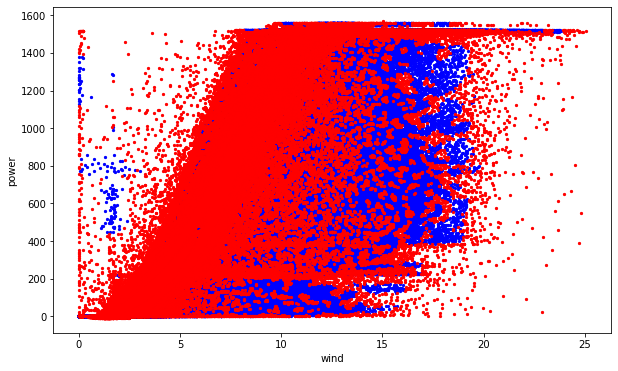

good_data: 0.8999999322119226, bad_data: 0.1000000677880773


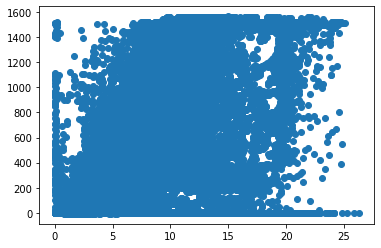

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')


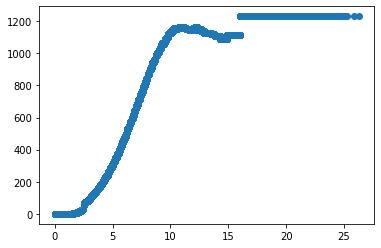

In [16]:
# 异常检测  idx2是规则检测，可以去除掉=======================================
del_rate = 0.10 
not_wash_data = part_data.loc[idx2, :]
wash_data = part_data.loc[~idx2, :]
good_data, bad_data = pyod_KNN(wash_data, outliers_fraction=del_rate, show=True)
g, b = len(good_data), len(bad_data)
print(f'good_data: {g / (g + b)}, bad_data: {b / (g + b)}')

# 异常修复====================================================================
# bad_data和not_wash_data都是坏的
bad_data = bad_data.append(not_wash_data)
plt.scatter(bad_data["Wspd"], bad_data["Patv"])
plt.show()

bad_data = pair_data(good_data, bad_data, p='0630_10')
plt.scatter(bad_data["Wspd"], bad_data["Patv"])
plt.show()

# bad_data需要做修正
finally_data = good_data.append(bad_data)
assert len(finally_data) == len(part_data)
finally_data = finally_data.sort_values(by=["TurbID", "Day", "Tmstamp"], ascending=True)
# print(finally_data)

finally_data.to_csv("./wtbdata_245days_0630.csv", index=False, header=True)

good_num:3540445 bad_num:885112


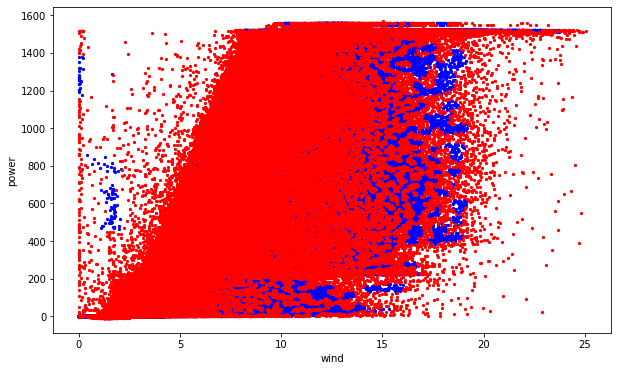

good_data: 0.7999998644238454, bad_data: 0.2000001355761546


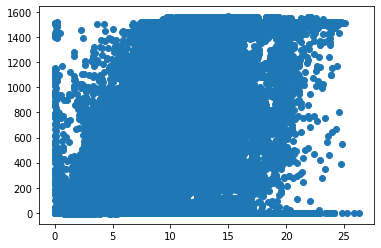

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')


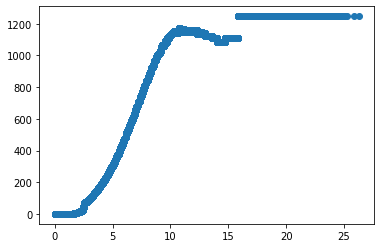

In [17]:
# 异常检测  idx2是规则检测，可以去除掉=======================================
del_rate = 0.20
not_wash_data = part_data.loc[idx2, :]
wash_data = part_data.loc[~idx2, :]
good_data, bad_data = pyod_KNN(wash_data, outliers_fraction=del_rate, show=True)
g, b = len(good_data), len(bad_data)
print(f'good_data: {g / (g + b)}, bad_data: {b / (g + b)}')

# 异常修复====================================================================
# bad_data和not_wash_data都是坏的
bad_data = bad_data.append(not_wash_data)
plt.scatter(bad_data["Wspd"], bad_data["Patv"])
plt.show()

bad_data = pair_data(good_data, bad_data, p='0630_20')
plt.scatter(bad_data["Wspd"], bad_data["Patv"])
plt.show()

# bad_data需要做修正
finally_data = good_data.append(bad_data)
assert len(finally_data) == len(part_data)
finally_data = finally_data.sort_values(by=["TurbID", "Day", "Tmstamp"], ascending=True)
# print(finally_data)

finally_data.to_csv("./wtbdata_245days_0630_p20.csv", index=False, header=True)

In [3]:
# 异常检测  idx2是规则检测，可以去除掉=======================================
del_rate = 0.20
not_wash_data = part_data.loc[idx2, :]
wash_data = part_data.loc[~idx2, :]
good_data, bad_data = pyod_KNN(wash_data, outliers_fraction=del_rate, show=True)
g, b = len(good_data), len(bad_data)
print(f'good_data: {g / (g + b)}, bad_data: {b / (g + b)}')

# 异常修复====================================================================
# bad_data和not_wash_data都是坏的
bad_data = bad_data.append(not_wash_data)
plt.scatter(bad_data["Wspd"], bad_data["Patv"])
plt.show()

bad_data = pair_data(good_data, bad_data, p=20,)
plt.scatter(bad_data["Wspd"], bad_data["Patv"])
plt.show()

# bad_data需要做修正
finally_data = good_data.append(bad_data)
assert len(finally_data) == len(part_data)
finally_data = finally_data.sort_values(by=["TurbID", "Day", "Tmstamp"], ascending=True)
# print(finally_data)

finally_data.to_csv("./wtbdata_245days_0629_p20.csv", index=False, header=True)

In [ ]:
# 线性三次方拟合, 为测试集做准备==================================================
# x3=finally_data["Wspd"].values**3
# x2=finally_data["Wspd"].values**2
# x1=finally_data["Wspd"].values
# l_data = pd.DataFrame({"x3":x3,"x2":x2,"x1":x1})
# l_model = linear_model.LinearRegression()
# l_model.fit(l_data,finally_data["Patv"].values)
# K=l_model.coef_
# B=l_model.intercept_
# MAX_P = np.max(finally_data["Patv"])
# PREY = K[0]*x3+K[1]*x2+K[2]*x1+B
# # plt.scatter(x1,PREY,s=3)
# # plt.scatter(x1,finally_data["Patv"].values,s=3)
# # plt.show()
# linear_param_dict[turbid]={"K":K,"B":B,"MAX_P":MAX_P} 

In [ ]:
# json_dir = "linear_repair.json"
# for k,v in linear_param_dict.items():
#     linear_param_dict[k]["K"] = list(linear_param_dict[k]["K"])
# with open(json_dir, "w") as f:
#     # 第一个就是本站的
#     print(linear_param_dict)
#     json.dump(linear_param_dict, f)

In [ ]:
data_dir = "./wtbdata_245days_0629.csv"
data = pd.read_csv(data_dir,index_col=None,header=0)
print(len(data))

### 单风机进行异常检测

1 35280
good_num:31234 bad_num:1643


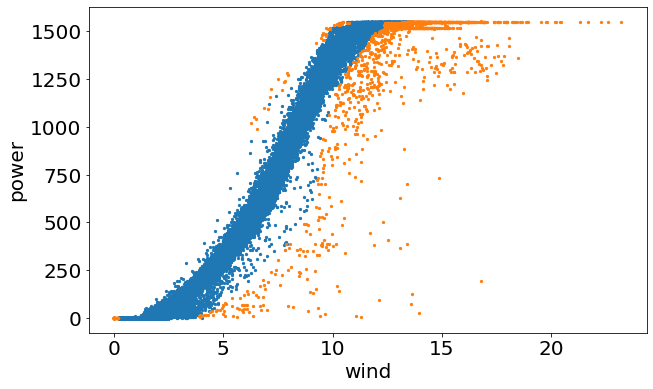

good_data: 0.9500258539404447, bad_data: 0.04997414605955531
Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')


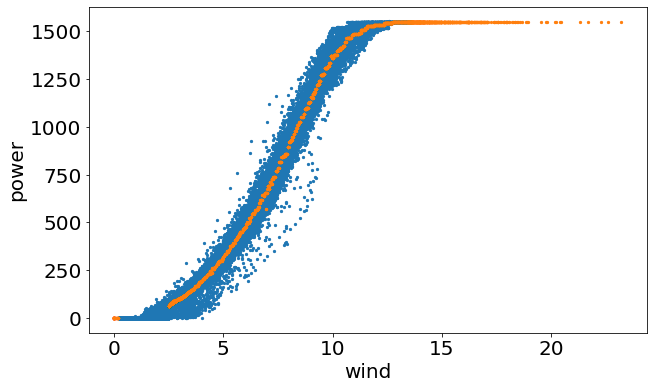

2 35280
good_num:31071 bad_num:1636


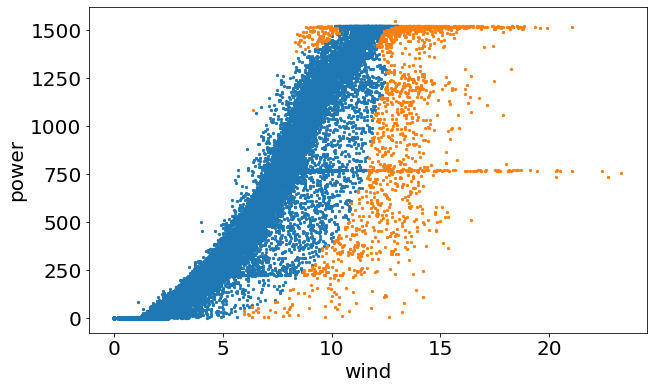

good_data: 0.9499801265784082, bad_data: 0.050019873421591705
Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')


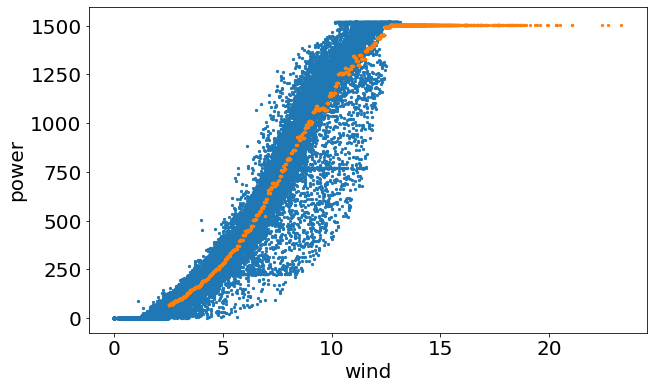

In [36]:
total_data = pd.DataFrame()
for turbid, part_data in part_data_list[0:2]:
    print(turbid,len(part_data))

    # 填充
    part_data = part_data.fillna(method="ffill")
    part_data = part_data.fillna(method="bfill")

    # Zero values
    idx1 = part_data["Patv"] < 0
    if np.sum(part_data.loc[idx1, ["Patv"]].values < -20) > 0:
        raise NameError(
            "有负值小于-20,{}".format(part_data.loc[part_data["Patv"] < -20, ["Patv"]]))
    part_data.loc[idx1, ["Patv"]] = 0
    # print(part_data.loc[idx1,["Patv"]].values)

    # Unknown values
    idx2 = ((part_data['Patv'] < 1) & (part_data['Wspd'] > 2.5))
    # plot_abnormal(turbid,part_data,idx2)

    # pab的未知数据20%以上，此处的处理严谨改进
    idx3_1 = part_data['Pab1'] > 89
    part_data.loc[idx3_1, ["Pab1"]] = 89
    idx3_2 = part_data['Pab2'] > 89
    part_data.loc[idx3_2, ["Pab2"]] = 89
    idx3_3 = part_data['Pab3'] > 89
    part_data.loc[idx3_3, ["Pab3"]] = 89

    # Abnormal values
    idx4 = part_data['Wdir'] < -180
    part_data.loc[idx4, ["Wdir"]] = -180
    idx5 = part_data['Wdir'] > 180
    part_data.loc[idx5, ["Wdir"]] = 180
    idx6 = part_data['Ndir'] < -720
    part_data.loc[idx6, ["Ndir"]] = -720
    idx7 = part_data['Ndir'] > 720
    part_data.loc[idx7, ["Ndir"]] = 720

    # 异常检测
    del_rate = 0.20
    not_wash_data = part_data.loc[idx2, :]
    wash_data = part_data.loc[~idx2, :]
    good_data, bad_data = pyod_KNN(wash_data, outliers_fraction=del_rate, show=True, fig_name=f'abnormal_{turbid}')
    g, b = len(good_data), len(bad_data)
    print(f'good_data: {g / (g + b)}, bad_data: {b / (g + b)}')

    # 异常修复
    # bad_data和not_wash_data都是坏的
    bad_data = bad_data.append(not_wash_data)
    # plt.scatter(bad_data["Wspd"], bad_data["Patv"])
    # plt.show()

    bad_data = pair_data(good_data, bad_data, p='single20', show=True, fig_name=f'pair_{turbid}')
    # plt.scatter(bad_data["Wspd"], bad_data["Patv"])
    # plt.show()

    # bad_data需要做修正
    finally_data = good_data.append(bad_data)
    assert len(finally_data) == len(part_data)
    # finally_data = finally_data.sort_values(by=["Day", "Tmstamp"], ascending=True)

    total_data = total_data.append(finally_data)

total_data = total_data.sort_values(by=["TurbID", "Day", "Tmstamp"], ascending=True)
# total_data.to_csv("./wtbdata_245days_0629_single20.csv", index=False, header=True)


### RidgeCV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from metrics import regressor_detailed_scores
import joblib

def find_param(pred, save_path):
    '''
    find better weights of models.
    pred: list(num_pred) preds shape: [134, 288]

    save_path: the path to save the ensemble model
    '''
    y = pd.read_csv('./predict_data_raw/test_y/0001out.csv').fillna(0)

    gt = y['Patv'].values.reshape(134, 1, 288, 1)

    cols_data = y.columns[3:]
    df_data = y[cols_data]

    raw_data = df_data.values
    raw_data = np.reshape(
        raw_data, [134, 288, len(cols_data)])

    raw_df = []
    for turb_id in range(134):
        raw_df.append(
            pd.DataFrame(
                data=raw_data[turb_id,:,:],
                columns=cols_data))
    mean_pred = np.concatenate(pred, axis=-1).mean(-1)
    _mae, _rmse = regressor_detailed_scores(mean_pred.reshape(134, 1, 288, 1), gt, raw_df, 134, 288)
    score1 = (_mae + _rmse) / 2
    print('the score of emsemble by mean:' , score1)

    X = np.concatenate(pred, axis=-1).reshape(134*288, -1)
    lin_reg = RidgeCV(alphas=np.logspace(0.1, 10, 20))
    lin_reg.fit(X, gt.reshape(-1))
    
    pred = lin_reg.predict(X)
    joblib.dump(lin_reg, save_path)
    print(pred.shape)
    mae, rmse = regressor_detailed_scores(gt, pred.reshape(134, 1, 288, 1), raw_df, 134, 288)
    score2 = (mae + rmse) / 2
    print('the score of ensemble by ridge:', score2)
    print(f'End! {score1} -> {score2}')
    print(f'Ensemble Weights: {lin_reg.coef_}')
    print(f'Sum of weights: {sum(lin_reg.coef_)}')

In [5]:
# np.logspace(0.1, 10, 20)
# Ensemble Weights: [-4.19490609  8.21360701  0.36961352 -1.0786158   4.21470329 -5.76195406
#  -4.9736279  -2.61237985  5.40618876  1.19955388  1.14398665]